In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl
import numpy as np
import sklearn.model_selection as skm
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.pyplot import subplots
from sklearn.pipeline import Pipeline
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError , R2Score, MeanSquaredError)
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
torch.manual_seed(0)
from ISLP.torch import (SimpleDataModule , SimpleModule , ErrorTracker , rec_num_workers)

In [2]:
# Ler a planilha CSV
nome_arquivo = 'winequality-white.csv'  # Substitua pelo nome do seu arquivo CSV
original = pd.read_csv(nome_arquivo, sep=';')
# Nome dos arquivos de treino e teste
nome_treino = 'treino.csv'
nome_teste = 'teste.csv'
# Ler as planilhas de treino e teste
treino = pd.read_csv(nome_treino, sep=';')
teste = pd.read_csv(nome_teste, sep=';')

In [3]:
# PRÉ-PROCESSAMENTO

# Função para padronizar os dados
def standardize(X):
    X_np = X.to_numpy()  # Convertendo a série para um array numpy
    Xs = X_np - X_np.mean(0)[None, :]
    X_scale = X_np.std(0)
    Xs = Xs / X_scale[None, :]
    return Xs

# TREINAMENTO
X_train = treino.drop(columns=['alcohol', 'quality'])
Xs_train = standardize(X_train)
Y_train = treino['alcohol']

# TESTE
X_test = teste.drop(columns=['alcohol', 'quality'])
Xs_test = standardize(X_test)
Y_test = teste['alcohol']

In [4]:
# Transformando os dados em tensores

X_train_t = torch.tensor(Xs_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.values.astype(np.float32))
train = TensorDataset(X_train_t , Y_train_t)

X_test_t = torch.tensor(Xs_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.values.astype(np.float32))
test = TensorDataset(X_test_t , Y_test_t)

In [5]:
# Criando um SimpleDataModule

max_num_workers = rec_num_workers()
dm = SimpleDataModule(train ,
                           test ,
                           batch_size=32, # Tamanho dos lotes
                           num_workers=min(4, max_num_workers),
                           validation=0.1) # Conjunto de validação será 10% do tamanho do conjunto de treiro

REDE NEURAL

In [6]:

class Network(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(Network, self).__init__()
        self.flatten = nn.Flatten()
        
        # Crie uma lista para armazenar as camadas da rede
        layers = []
        in_features = input_size
        
        for out_features in hidden_layers:
            # Adicione uma camada linear seguida de uma função de ativação Sigmoid
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.Sigmoid())
            in_features = out_features  # Atualize o número de neurônios de entrada para a próxima camada
        
        # Adicione a camada de saída
        layers.append(nn.Linear(in_features, 1))
        
        # Crie a sequência de camadas
        self.sequential = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))


In [7]:
# Função para salvar o RMSE durante o treinamento
def summary_plot(results, ax, col='loss', valid_legend='Validation', training_legend='Training', ylabel='Loss', fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'], ['black', 'red'], [training_legend, valid_legend]):
        ax.plot(results['epoch'], results[column], label=label, marker='o', color=color)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.legend()
    return ax

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 11    
1 | loss  | MSELoss | 0     
----------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:00<00:00, 116.62it/s, v_num=7]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 226.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.14401865005493164
        test_rmse           0.3794978857040405
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 121   
1 | loss  | MSELoss | 0     
----------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 93.81it/s, v_num=8]        

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 148.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.13708026707172394
        test_rmse           0.37024351954460144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 231   
1 | loss  | MSELoss | 0     
----------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 68.85it/s, v_num=9]        

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 169.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.12163733690977097
        test_rmse           0.34876543283462524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 11    
1 | loss  | MSELoss | 0     
----------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 68.99it/s, v_num=10]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 181.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.14628762006759644
        test_rmse           0.3824756443500519
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 601   
1 | loss  | MSELoss | 0     
----------------------------------
601       Trainable params
0         Non-trainable params
601       Total params
0.002     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:00<00:00, 107.85it/s, v_num=11]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 218.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.26761531829833984
        test_rmse           0.5173155069351196
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 3.2 K 
1 | loss  | MSELoss | 0     
----------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 78.61it/s, v_num=12]       

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 195.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.10998673737049103
        test_rmse           0.3316424787044525
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 11    
1 | loss  | MSELoss | 0     
----------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 73.62it/s, v_num=13] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 155.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.13727310299873352
        test_rmse           0.37050384283065796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 1.2 K 
1 | loss  | MSELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:00<00:00, 111.83it/s, v_num=14]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 180.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.10365569591522217
        test_rmse           0.3219560384750366
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 11.3 K
1 | loss  | MSELoss | 0     
----------------------------------
11.3 K    Trainable params
0         Non-trainable params
11.3 K    Total params
0.045     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 69.55it/s, v_num=15]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 158.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.09229614585638046
        test_rmse           0.30380281805992126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 11    
1 | loss  | MSELoss | 0     
----------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:00<00:00, 111.84it/s, v_num=16]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 223.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.20996801555156708
        test_rmse           0.4582226574420929
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 6.0 K 
1 | loss  | MSELoss | 0     
----------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 80.42it/s, v_num=17]       

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 135.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.28564703464508057
        test_rmse           0.5344595909118652
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 256 K 
1 | loss  | MSELoss | 0     
----------------------------------
256 K     Trainable params
0         Non-trainable params
256 K     Total params
1.026     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:02<00:00, 43.49it/s, v_num=18]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 113.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.161083698272705
        test_rmse            1.470062494277954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 11    
1 | loss  | MSELoss | 0     
----------------------------------
11        Trainable params
0         Non-trainable params
11        Total params
0.000     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:00<00:00, 117.37it/s, v_num=19]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 239.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.14392492175102234
        test_rmse           0.3793743848800659
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 1.2 K 
1 | loss  | MSELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 103.87it/s, v_num=20]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 171.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22449924051761627
        test_rmse           0.4738135039806366
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 11.3 K
1 | loss  | MSELoss | 0     
----------------------------------
11.3 K    Trainable params
0         Non-trainable params
11.3 K    Total params
0.045     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 104/104 [00:01<00:00, 69.34it/s, v_num=21]       

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 39/39 [00:00<00:00, 89.82it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.16296587884426117
        test_rmse           0.4036903381347656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\782491446.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

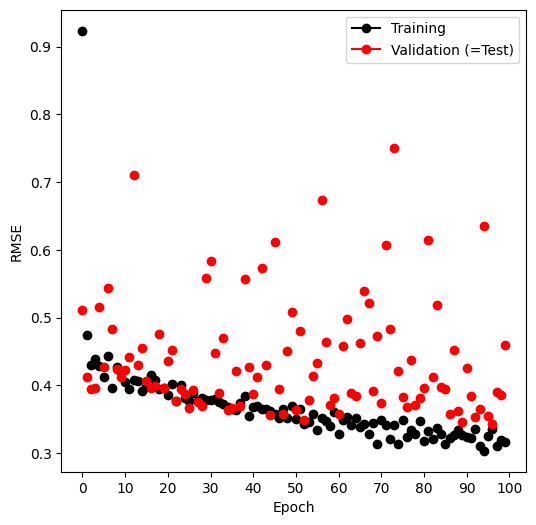

In [8]:
# Testando diferentes arquiteturas de rede

n_layers = 20

n_neuronios = [10, 50, 100, 200]

data = pd.DataFrame(columns=['Quantidade de Layers', 'Número de Neurônios', 'MSE', 'RMSE', 'R2'])

for n_neuronio in n_neuronios:
    for n in range(n_layers):
        # Criando a rede neural
        hidden_layers = np.full(n, n_neuronio)
        model = Network(Xs_train.shape[1], hidden_layers)
        
        # Definindo o modulo com a métrica RMSE
        module = SimpleModule.regression(model, metrics={'rmse': MeanSquaredError(squared=False)})
        
        # Objeto para salvar os arquivos logs
        logger = CSVLogger('logs', name='white_wine')
        
        # Treinando a rede
        n_epochs = 100
        trainer = Trainer(deterministic=True,
                          max_epochs=n_epochs, # Número de épocas
                          log_every_n_steps=5, # Número de passos em que serão salvas informações
                          logger=logger , # Logger em que serão salvas as informações
                          callbacks=[ErrorTracker()])
        trainer.fit(module , datamodule=dm)
        
        # Avaliando a performance do modelo para o conjunto de teste
        trainer.test(module , datamodule=dm)
        
        # Criando um plot de MAE (mean absolute error) em função do número de épocas
        results = pd.read_csv(logger.experiment.metrics_file_path)
        
        plt.clf()
        fig, ax = subplots(1, 1, figsize=(6, 6))
        ax = summary_plot(results,
                        ax,
                        col='rmse',
                        ylabel='RMSE',
                        valid_legend='Validation (=Test)')
        #ax.set_ylim([0, 400])
        ax.set_xticks(np.linspace(0, n_epochs, 11).astype(int));
        filename = f"imagens/Neural_Network/RMSE_{n}_{n_neuronio}.png"        
        plt.savefig(filename)        
        
        # Coloque o modelo em modo de avaliação
        model.eval()

        # Faça as previsões com o modelo
        preds = model(X_test_t)
        
        # Converta os tensores para arrays NumPy para calcular o R²
        preds = preds.detach().cpu().numpy()
        
        mse = mean_squared_error(Y_test,preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(Y_test, preds)
        
        data = data.append({'Quantidade de Layers': n, 'Número de Neurônios': n_neuronio, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
        
        del(model , trainer , module, logger)
        

C:\Users\Artemisa\AppData\Local\Temp\ipykernel_14376\2238698612.py:11: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(x="Quantidade de Layers", y="RMSE", hue="Número de Neurônios", data=data, marker="o", palette=sns.color_palette("tab10"), alpha=1)


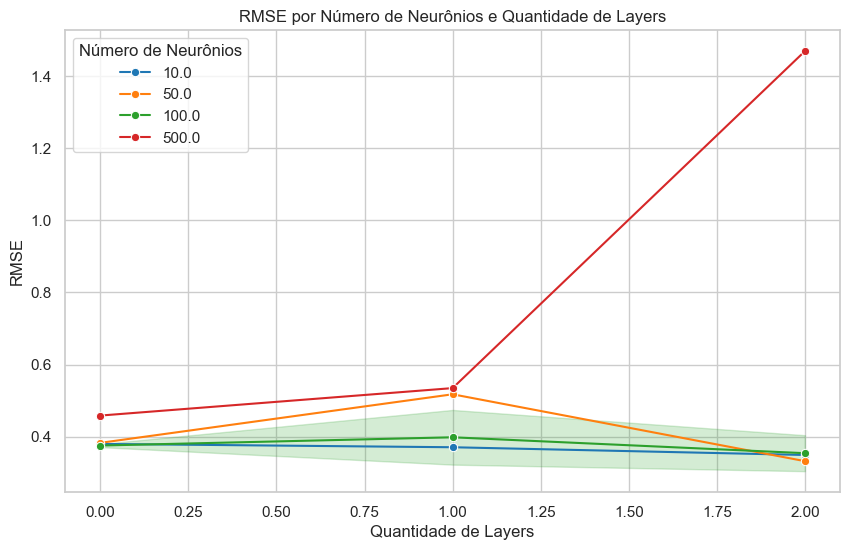

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure o estilo dos gráficos e use a paleta personalizada
sns.set(style="whitegrid", palette=sns.color_palette("tab10"))

# Crie o gráfico de linhas com as séries de RMSE
plt.figure(figsize=(10, 6))  # Ajuste o tamanho da figura conforme necessário

# Use o seaborn para criar o gráfico de linhas e ajuste a transparência (alpha) para 1
sns.lineplot(x="Quantidade de Layers", y="RMSE", hue="Número de Neurônios", data=data, marker="o", palette=sns.color_palette("tab10"), alpha=1)

# Adicione um título ao gráfico
plt.title("RMSE por Número de Neurônios e Quantidade de Layers")

# Mostre o gráfico
plt.show()
